In [11]:
import os, sys, time

sys.path

import numpy as np

import matplotlib
# matplotlib.use('PDF')
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import emcee, corner

import pandas as pd
%matplotlib inline

#### Data explanation

In the data files, from first to last column: 

  1) offset in arcsec**, 
  
  2) intensity in Jy/beam, 
  
  3) error or stand dev* (same unit as intensity), 
  
  4) beam major axis (arcsec), 
  
  5) beam minor axis (arcsec).

# Define class and function

In [189]:
mksflux_to_Jy = 1e26
c_mks         = 299792458.0     # light speed in m/s
kB_mks        = 1.38064852e-23  # Boltzmann constant


def solidang_sr(maj_arcsec, min_arcsec):
    """
    
    Return solid angle in unit of Sr.
    
    Input :
    
    maj_arcsec, min_arcsec [float] : major/minor axis HPBW in units of arcseconds.
    
    
    Return :
        Omega_sr [float] : solid angle in units of Sr.
    
    """
    Omega_sr = np.pi \
                  * maj_arcsec * (np.pi / 180.0) / 3600.0 \
                  * min_arcsec * (np.pi / 180.0) / 3600.0
    Omega_sr =  Omega_sr / (  4.0 * np.log(2.0) )

    return Omega_sr


def brightnessT(flux_Jy, beamHPBWmaj_arcsec, beamHPBWmin_arcsec, freqGHz):
    '''
    Return brightness temperature.
    
    Inputs :
        flux_Jy [float] : flux density in units of Jy.
        beamHPBWmaj_arcsec, beamHPBWmin_arcsec [floats] : beam major/minor axes (FWHM), in units of arcsec
        freqGHz [float] : Observing frequency
    
    Return :
        Tb_Kelvin [float] : brightness temperture in unit of Kelvin.
    
    '''

    # beam solid angle
    Omega_sr = solidang_sr(beamHPBWmaj_arcsec, beamHPBWmin_arcsec)

    # flux unit conversion to MKS
    flux_mks = flux_Jy / mksflux_to_Jy

    # frequency unit conversion to Hz
    freqHz = freqGHz* 1e9

    # evaluate brightness temperature
    Tb_Kelvin = ( flux_mks / Omega_sr )  * \
          ( c_mks**2.0 /  (2.0 * kB_mks * (freqHz**2.0) ) )

    return Tb_Kelvin





class profilefit:
    '''
    A class to handle the profile fitting (using MCMC, which is powered by the emcee package).
    The fitting takes into consideration of Gaussian beam.
    
    An object of this class can be initialized by specifying a filename which is an ASCII file
    storing the offsets, intensity, and errors of intensity in the 0th, 1st, and 2nd columns, 
    respectively. If the filename is not given during the initialization,
    the file can also be loaded with the load_profile() function.
    It is assumed that the offsets are linearly and regularly spaced.
    
    Attributes:
        DataFrame [pandas data frame] : created after loading the ASCII data file.
                                        It includes three columns: offset, intensity, intensity_err
        num_rows  [integer]           : number of rows in the input data
        sigma     [float]             : angular resolution in units of arcsecond.
        
    
    Example:
    profilefit = profilefit()
    profilefit.load_profile(
                            filename = 'IRS63_b6_pa147.91_major.txt'
                           )
    '''
    
    def __init__(self, 
                 filename = ''):
        self.ifBrightness = False
        if (filename != ''):
            self.load_profile(filename = filename)
    
    def __del__(self):
        pass
    
    ########################################################################################
    #     Methods
    ########################################################################################
    
    def load_profile(self, filename = '', 
                     scale_x=1.0, scale_y=1.0, 
                     ifBrightness=False, 
                     bmaj=0.04063, bmin=0.03567, bpa=0.0, freqGHz=225.0,
                     slicepa=0.0):
        '''
        Loading input ASCII data file.
        
        Inputs:
            filanem [string] : Input filename.
            scale_x [float]  : A scaling fector for the offset values (e.g., to change units; default:1.0).
            scale_y [float]  : A scaling factor for the intensity values (e.g., to change units; default:1.0).
            ifBrightness [T/F] : True: convert input to brightness temperature. False: Not convert.

            bmaj/bmin [floats] : synthesized beam major and minor axes.
            bpa       [float]  : beam position angle [in unit of degree]
            freqGHz   [float]  : observing frequency.
            slicepa   [float]  : position angle of the slice
        '''
        try:
            print('Loading file :', filename)
            
            self.DataFrame = pd.read_csv(filename, sep=' ', usecols = [0, 1, 2],
                                         header=None, names=["offset", "intensity", "intensity_err"])
            self.num_rows = np.size(self.DataFrame.intensity)
            self.ifBrightness = ifBrightness
            
            ### Give zero uncertainties with some values #########################
            # this part is very unhealthy. Should fix the measurement
            self.DataFrame.intensity_err = self.DataFrame.intensity_err
            elements = np.where(self.DataFrame.intensity_err == 0.0
                               )
            elements = np.array(elements[0])
            self.DataFrame.intensity_err[elements] = self.DataFrame.intensity_err[elements] + 0.00001
            ######################################################################
  
            if self.ifBrightness == False:
                self.DataFrame.offset    = self.scale_x
                self.DataFrame.intensity = self.DataFrame.intensity * scale_y
                self.DataFrame.intensity_err = self.DataFrame.intensity_err * scale_y
            else:
                self.DataFrame.intensity = brightnessT(self.DataFrame.intensity, 
                                                       bmaj, bmin, freqGHz)
                self.DataFrame.intensity_err = brightnessT(self.DataFrame.intensity_err, 
                                                       bmaj, bmin, freqGHz)
                
            # evaluate the angular resolution in the direction of the slice
            self.sigma = self.get_sigma(bmaj, bmin, bpa, slicepa)
                        
        except:
            print('Error loading profile data. Please double check the path or the content in the file.')
            

    def initialize_mcmc(self, nwalkers=1, init_parms=[] ):
        '''
        Fit a power-law profile and return the best-fit power-law index.
        
        Input:
            nwalkers   [int]          : Number of mcmc walkers (default: 1)
            init_parms [float list]   : An initial guess for parameters (default: [])
        '''
        self.nwalkers          = nwalkers
        self.parms             = np.array(init_parms)
        self.get_initial_pos()
    
    
    def get_initial_pos(self):
        '''
        Obtain initial positions for the MCMC samplers.
        Tentatively use the initial guess + the normal distributions that the width are 0.2 times the
        initial guess
        '''
        self.initial_pos = [
                self.parms  + 
                self.parms  * 0.2 * np.random.randn( len(self.parms) )
               for i in range(self.nwalkers)
              ]
        
        
    def get_model(self, parms, model_type='single_power_law'):
        '''
        
        Input:
        
        Return:
        
            model [1d numpy array] : the model values at the positions x
        '''
        x = self.DataFrame.offset
        
        if model_type == 'single_power_law':
            A0, r0, index = parms[0], parms[1], parms[2]
            model = self.powerlaw(np.absolute(x), A0, r0, index)
            model = np.array(model)
            
            # Set an upper limit of dust temperature to 1500 K
            index = np.where( np.isfinite(model) == False )
            if ( np.size(index)>0 ):
                model[index] = 1500.0
            index = np.where( model > 1500.0 )
            if ( np.size(index)>0 ):
                model[index] = 1500.0
            
            # convolve a Gaussian beam
            model = self.gaussian_convolve(model, x, self.sigma)
            
        return model
    
    
    def summarize_mcmc(self):
        '''
        Make a summary of the MCMC result
        '''
        pass
    
    
    def output_samples(self):
        '''
        Output the samplers to a ASCII file.
        '''
        pass
    
    
    def make_corner(self):
        '''
        Produce a corner plot.
        '''
        pass
    
    
    def plot_profile(self, outfigname='temp_profile.pdf', 
                label='None', 
                     label_fontsize=14,
                tick_fontsize=14,
                x_label='Offset', y_label='Intensity',
                     x_label_fontsize=14, y_label_fontsize=14,
                data_color=(0.2,0.2,0.2,1), elinewidth=1.0,
                xlim=[], ylim=[], 
                xscale='linear', yscale='linear',
                figsize=[10,6], plot_range=[0.14, 0.1, 0.85, 0.85],
                plot_model=True,
                    model_color=(1,0,0,0.5), model_linewidth=2.0):
        '''
        Plot the loaded ASCII data files (and the fitted profile, if exist).
        
        Inputs:
        outfigname      [str]       : Name of the output figure.
        label           [str]       : A label inside the panel.
        label_fontsize  [float]     : fontsize for the label.
        tick_fontsize   [float]     : fontsize for the ticks. 
        x_label, y_label  [str]        : Labels for the x and y axes.
        x, y_label_fontsize=14 [float] : fontsizes of the x and y labels.
        data_color                  : (R,G,B) color for the data.
        elinewidth      [float]     : linewidth for the errorbar.
        xlim, ylim  [list of float] : X and y ranges for plotting
        figsize, plot_range, xlim, ylim, xscale, yscale : normal matplotlib parameters.
        plot_model      [True/False] : If true, plot the model. If there is a final mcmc result,
                                       plot it; otherwise, plot the initial guess.
        model_color                 : (R,G,B, alpha) in matplotlib syntax. Default: (1,0,0,0.5)
        model_linewidth [float]     : default: 2.0
        '''
        fig = plt.figure(figsize=figsize)
        ax = fig.add_axes(plot_range)
        
        # plot model
        if plot_model == True:
            #try:
                model = self.get_model(self.parms)
                plt.plot(self.DataFrame.offset, model,
                       color=model_color, linewidth=model_linewidth )
            #except:
            #    pass
        
        # plot error-bar
        ax.errorbar(self.DataFrame.offset, self.DataFrame.intensity, 
                    yerr=self.DataFrame.intensity_err, 
                    color=data_color, 
                    ecolor=data_color, elinewidth=elinewidth)
        
        plt.tick_params(labelsize=tick_fontsize)
        plt.xlabel(x_label, fontsize=x_label_fontsize)
        plt.ylabel(y_label, fontsize=y_label_fontsize)
        plt.xscale(xscale)
        plt.yscale(yscale)
        
        if (label != 'None'):
            ax.text(0.02, 0.92, label, transform=ax.transAxes,
                     color=(0,0,0,1),
                     fontsize=label_fontsize, horizontalalignment='left')
        
        plt.show()
        plt.savefig(outfigname)       
            
    ########################################################################################
    #     Function
    ########################################################################################
    
    def get_sigma(self, bmaj, bmin, bpa, slicepa):
        '''
        Return the angular resolution in the direction of the slice.
        
        '''
        diff_pa = slicepa - bpa
        diff_pa = diff_pa * (np.pi / 180.0)
        sigma   = np.sqrt(
                          (bmaj * np.cos(diff_pa) )**2.0 +
                          (bmin * np.sin(diff_pa) )**2.0
                         )
        
        return sigma
    
    def gaussian_1d(self, x, x0, sigma):
        '''
        Return a Gaussian distribution that is normalized to 1.0
        
        
        Input:
            x [1d np array] : offset
            x0 [float]      : central position of the Gaussian
            sigma [float]   : standard deviation of the Gaussian
        '''
        
        A = 1.0 / (sigma * np.sqrt(2.0 * np.pi))
        B = -0.5 * (( (x - x0)/sigma )**2.0)
        
        return A * np.exp(B)
    
    
    def powerlaw(self, x, A0, r0, index):
        '''
        create a power-law that is A0 * ( (r/r0)**index )
        
        Input:
            x [1d np array] : offset
            A0      [float] : the value of the power law at the location r=r0
            r0      [float] : a reference location.
            index   [float] : power-law index
        '''
        
        return A0 * ( (np.absolute(x)/r0)**index )
        
    
    def gaussian_convolve(self, function, x, sigma):
        '''
        Return a convolution of function with a 1d gaussian that has sigma standard deviation.
        
        Input:
            function [1d np array] : A 1-dim function to be convolved with a Gaussian;
                                     this function is a function of offset x.
            x [1d np array] : offset
            sigma [float]   : standard deviation of the Gaussian.
        '''
        num_ele      = np.size(function)
        out_function = np.zeros(num_ele)
        delta_x      = np.absolute( x[1] - x[0] )
        
        for i in range(0, num_ele):
            x0 = x[i]
            out_function += function[i] * self.gaussian_1d(x, x0, sigma) * delta_x
        
        return out_function
    
    
    def lnprior(self, parms, priortype='flat'):
        '''
        Evaluate and return the contribution of prior to log probability.
        '''
        
        if priortype == 'flat':
            return 0.0
        
    
    def lnprob(self, parms):
        '''
        Return the logged probability
        
        
        Input:
            parms [1d np array] : model parameters: [A0, r0, index]
        '''
        
        # evaluate prior probability distribution
        lp = self.lnprior(parms)
        if not np.isfinite(lp):
            return -np.inf        
        
        # initialize probability
        temp_prob = 0.0 + lp
        
        # evalute model profile
        model = self.get_model(parms)
        model = np.array(model)
        
        # evaluate log probability
        index = np.where( self.DataFrame.intensity > 0 )
        intensity = np.array(self.DataFrame.intensity)
        err       = np.array(self.DataFrame.intensity_err)
        temp_prob += -0.5 * (
                             np.sum(
                                    ( ( intensity[index] - model[index] )**2 ) /
                                    ( err[index]**2 )
                                   )
                            )
        
        return temp_prob
        
    
    

Loading file : ../../cuts_profiles/IRS63_b6_pa147.91_major.txt


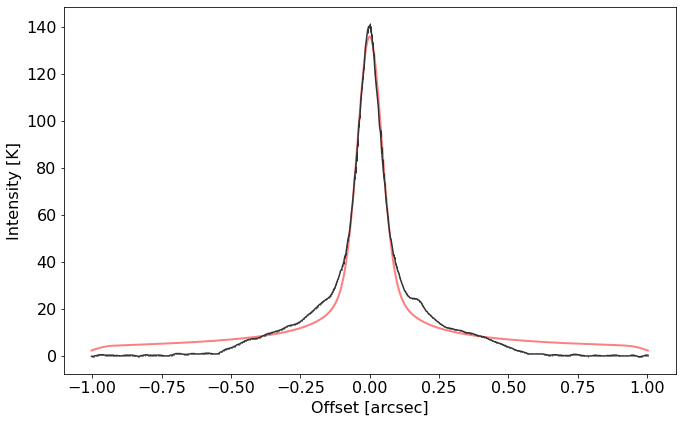

-97619.92462778423
-981520.525031914


<Figure size 432x288 with 0 Axes>

In [208]:


path = '../../cuts_profiles/'
filename = 'IRS63_b6_pa147.91_major.txt'
test = profilefit()
test.load_profile(filename = path + filename, 
                  ifBrightness=True
                 )

test.initialize_mcmc(nwalkers=3, init_parms=[10.0, 0.3, -0.75])
test.plot_profile(
                  # xscale='log', yscale='log',
                  x_label='Offset [arcsec]', y_label='Intensity [K]',
                  x_label_fontsize=16, y_label_fontsize=16,
                  tick_fontsize=16,
                 )


x = np.array( range(0,512) )


gaussian1 = test.gaussian_1d(x, 2.0, 2.0)
# test.gaussian_convolve(gaussian1, np.array( range(0,512) ), 5.0)

# test.powerlaw(x, 1, 0.2, -1.5)

print( test.lnprob([10.0,0.3,-0.9]) )
